In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Ejercicio 1. Para una gráfica no necesariamente conexa, exhiba una manera de construir un árbol generador para cada componente conexa.

Solucion. En clase vimos que toda grafica $G = (V,E)$ contiene un arbol generador. Esta solución esta basada en la demostración de ese resultado. Especificamente, construiremos un bosque generador $F$ de la siguiente manera:

Denotemos $V = \{ v_0, \dots, v_n \}$ y sea $v_0 \in V$ el primer vertice. (En la implementación, el conjunto de vertices es una lista ordenada, así que tiene sentido hablar del 'primer' vertice.) Definimos

$$V_0 = \{ v_0 \} \cup \{ w \in V \mid \{v_0, w\} \in E \}, \qquad E_0 = \{ \{v_0, w\} \mid w \in V_0 \setminus \{ v_0 \} \}.$$

Recursivamente definimos

$$V_k = \{ v_k \} \cup \left\{ w \in V \setminus \bigcup_{i=0}^{k-1} V_i \mid \{v_k, w\} \in E \right\}, \qquad E_k = \{ \{v_k,w\} \mid w \in V_k \setminus \{ v_k \} \}.$$

Finalmente, definimos
$$F = \left( V, \bigcup_{k=1}^n E_k \right).$$

Para ver que $F$ es un arbol, supongamos que $v_{i_1}, \dots, v_{i_p}$ es un ciclo y que la sucesión $i_1, \dots, i_p$ es estrictamente creciente. En particular, $\{ v_{i_p}, v_{i_1} \} \in \bigcup_{k=1}^n E_k$. Mas aun, (por definición de los $E_k$) tendriamos $\{ v_{i_p}, v_{i_1} \} \in E_{i_p} \cup E_{i_1}$. Si $\{ v_{i_p}, v_{i_1} \} \in E_{i_p}$, entonces $v_{i_1} \in V_{i_p} \subset V \setminus V_{i_1}$ (pues $i_1 < i_p$). Una contradicción. Por lo tanto, $\{ v_{i_p}, v_{i_1} \} \in E_{i_1}$. Pero entonces $v_{i_p} \in V_1$. Contradiciendo $v_{i_p} \in V_{i_p} \subset V \setminus V_{i_1}$.

El siguiente codigo esta basado en esta construcción.

In [2]:
def gforest(G):

  F = nx.Graph()

  for v in list(G.nodes):
    F.add_node(v)
    for w in list(set(G.nodes) - set(F.nodes)):
      if w in list(G.adj[v]):
        F.add_edge(v,w)

  return F

Un ejemplo:

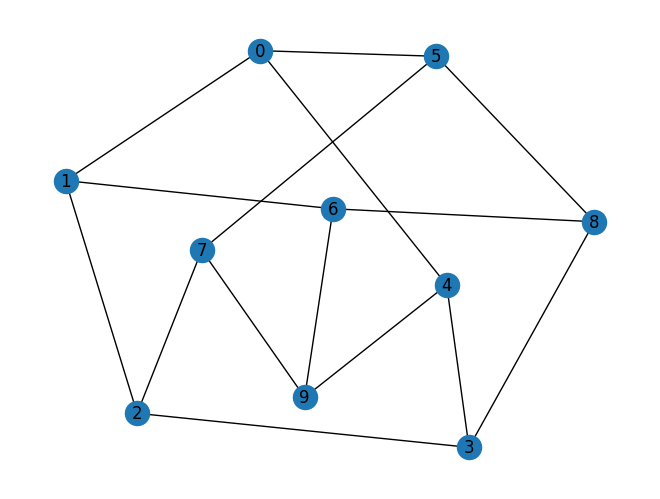

In [3]:
G = nx.petersen_graph()
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, with_labels=True)

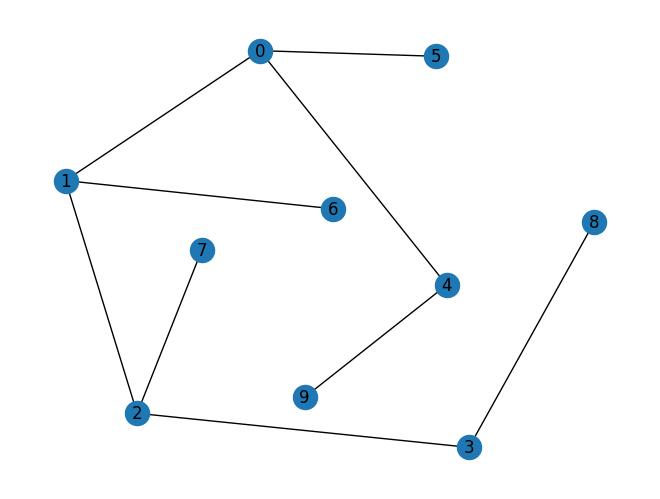

In [4]:
nx.draw(gforest(G), pos, with_labels=True)

Otro ejemplo:

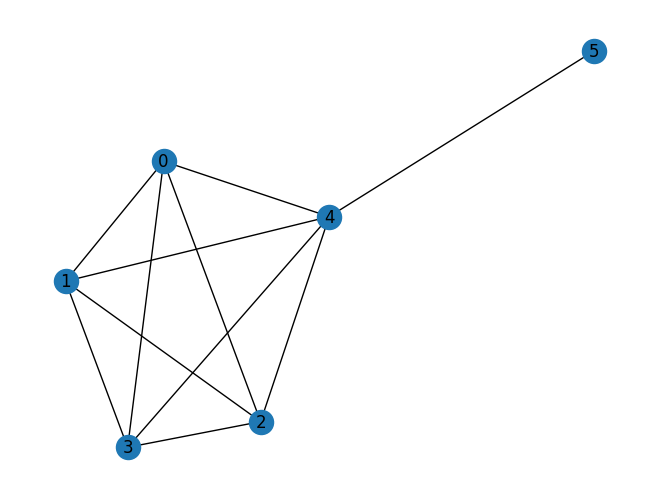

In [5]:
G = nx.lollipop_graph(5,1)
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, with_labels=True)

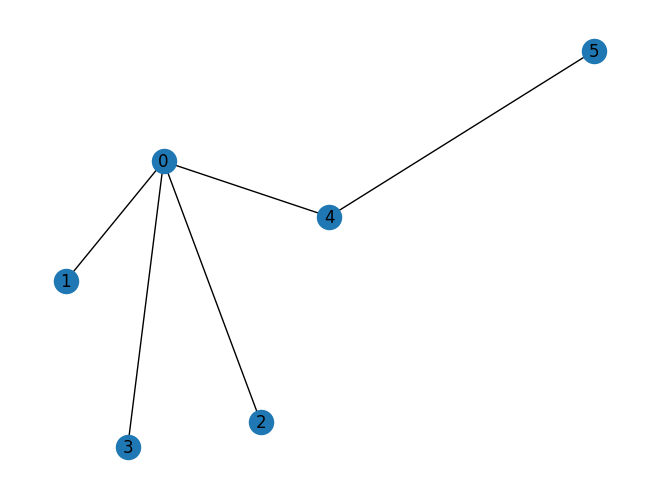

In [6]:
nx.draw(gforest(G), pos, with_labels=True)

Antes de continuar, describiremos la estructura de datos union-find.

Sea $F = (V,E)$ un bosque y sean $(T_i = (V_i,E_i))_{i=0}^n$ los arboles que componen a $F$. Para cada arbol $T_i$ escogemos una raiz $r_i$. Definimos $\text{par} : V \to V$ por

$$
\text{par}(v) =
\begin{cases}
\text{el vecino de $v$ mas cercano a $r_i$} & \text{ si } v \in V_i \setminus \{ r_i \} \\
r_i & \text{ si } v = r_i
\end{cases}
$$

Decimos que $w$ es descendiente de $v$ si $w \not = \text{par}(v)$ y existe un camino de $w$ a $v$. Para cada $v \in V$ definimos $\text{rank}(v)$ como el numero de descendientes de $v$.

Esta es la estructura inicial. Las operaciones son las siguientes.

La operacion find encuentra la raiz del arbol al cual pertenece un vertice dado. Es decir, $\text{find}(v) = r_i$ si $v \in V_i$. En la implementación aplicamos la funcion $\text{par}$ hasta llegar a la raiz. Cabe recalcar que la forma en la que reconocemos ya que llegamos a la raiz es porque $r$ es una raiz ssi $\text{par}(r) = r$. Especificamente, usamos la siguiente funcion:

```
def find(node):
  repr = node
  while repr != par[repr]:
    repr = par[repr]
  return repr
```

Sean $v,w \in V$ y supongamos que $v \in T_i$ y $w \in T_j$. Si $T_i = T_j$, la operacion $\text{find}(u,v)$ no hace nada. Pero si $T_i \not = T_j$ la operacion $\text{find}(u,v)$ crea una arista entre $r_i$ y $r_j$. Esto cambia nuestro conjunto de arboles $(T_i)_{i=0}^n$ de la manera obvia - quitamos $T_i$ y $T_j$, y agregamos el arbol con vertices $V_i \cup V_j$ y aristas $E_i \cup E_j \cup \{ r_i, r_j \}$. Notemos que al hacer esto, no hay manera obvia de determinar la raiz del nuevo arbol. Aqui es donde entra el concepto de rank. Simplemente definimos la raiz como aquella que tenga mayor rank. Especificamente,

*   Si $\text{rank}(r_i) < \text{rank}(r_j)$, redefinimos $\text{par}(r_i) = r_j$.
*   Si $\text{rank}(r_i) \geq \text{rank}(r_j)$, redefinimos $\text{par}(r_j) = r_i$.

Cabe recalcar que el caso en que los ranks coinciden es dependiente de si llamamos $\text{find}(v,w)$ o $\text{find}(w,v)$. Especificamente, usamos la siguiente funcion:

```
def union(n1, n2):
  p1, p2 = find(n1), find(n2)
  if p1 != p2:
    if rank[p1] < rank[p2]:
      par[p1] = p2
      rank[p2] += rank[p1]
    else:
      par[p2] = p1
      rank[p1] += rank[p2]
```

Ejercicio 2. Describa el algoritmo de Kruskal para encontrar el mínimo árbol generador de una gráfica.

Solucion. Supongamos que $G = (V,E)$ es una grafica con pesos arbitraria. Usaremos la estructura de datos union-find.

1.   Antes que nada, ordenamos ascendentemente las aristas de $(V,E)$ dependiendo del peso. Especificamente, creamos una lista sorted_edges de manera que si $i \leq j$, entonces el peso de sorted_edges[ i ] es menor o igual que el peso de sorted_edges[ j ]. Cabe recalcar que si los pesos coinciden, el orden es irrelevante.
2.   Creamos el bosque $F$ generado por los arboles $T_i = (\{ v_i \}, \emptyset)$. Es decir, cada arbol consiste de un solo vertice. Entonces tendremos que $\text{rank}(v) = 0$ y $\text{par}(v) = v$ para todo $v \in V$.
3. Finalmente, hacemos un for loop sobre sorted_edges que hace lo siguiente: Digamos que vamos en la arista $(\{ v,w \}, \text{weight})$. Si $\text{find}(v) = \text{find}(w)$, no hacemos nada. Si $\text{find}(v) \not = \text{find}(w)$, aplicamos $\text{union}(v,w)$ y agregamos la arista $(\{ v,w \}, \text{weight})$ al bosque $F$. Especificamente:

```
for edge in sorted_edges:
    if find(edge[0]) != find(edge[1]):
      union(edge[0], edge[1])
      A = [(edge[0], edge[1], edge[2]['weight'])]
      F.add_weighted_edges_from(A)
```
De esta manera, $F$ es un bosque generador minimal. Con un argumento inductivo, se puede demostrar que $F$ es en efecto un bosque. La observacion importante es que las unicas aristas que agregamos a $F$ son tales que unen (desde la raiz) a dos arboles disjuntos. La minimalidad es consecuencia de que primero agregamos los ejes de menor peso.

In [7]:
def kruskal(G):

  get_weight = lambda edge: edge[2]['weight']
  sorted_edges = sorted(G.edges(data=True), key=get_weight)

  n = G.number_of_nodes()
  par = [i for i in range(n)]
  rank = [0] * n
  F = nx.Graph()

  def find(node):
    repr = node
    while repr != par[repr]:
      repr = par[repr]
    return repr

  def union(n1, n2):
    p1, p2 = find(n1), find(n2)
    if p1 != p2:
      if rank[p1] < rank[p2]:
        par[p1] = p2
        rank[p2] += rank[p1]
      else:
        par[p2] = p1
        rank[p1] += rank[p2]

  for edge in sorted_edges:
    if find(edge[0]) != find(edge[1]):
      union(edge[0], edge[1])
      A = [(edge[0], edge[1], edge[2]['weight'])]
      F.add_weighted_edges_from(A)

  return F

Un ejemplo:

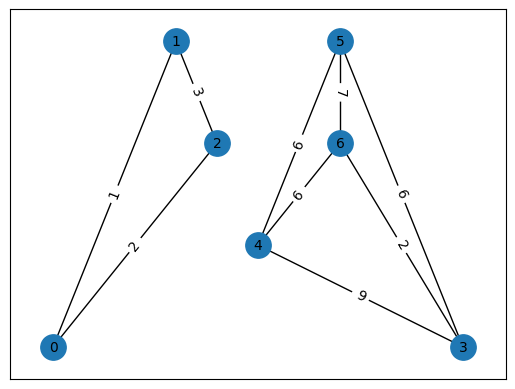

In [8]:
G1 = nx.Graph()
G1.add_weighted_edges_from([(0,1,1), (0,2,2), (1,2,3)])

G2 = nx.complete_graph(4)
for edge in list(G2.edges):
  G2.edges[edge[0],edge[1]]['weight'] = np.random.randint(0,10)

G = nx.disjoint_union(G1, G2)

pos = nx.planar_layout(G)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_nodes(G, pos, node_size=333)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()

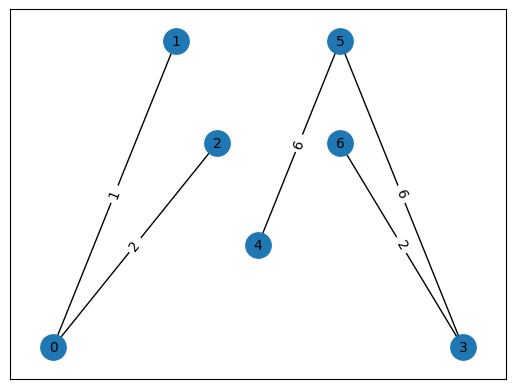

In [9]:
G = kruskal(G)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_nodes(G, pos, node_size=333)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()

Ejercicio 3. Encuentre en algun lugar una manera efectiva de incluir un arbol de manera vectorial.

Solucion. Sea $V = \{ v_0, \dots, v_{n-1} \}$. En caso de que tengamos una estructura de datos union-find, el vector

$$
(\text{par}(v_i))_{i=0}^{n-1}
$$

determina el bosque. Si quisieramos modificarlo para que sea como lo vimos en el video, cambiamos las entradas de las raices a $- (1+\text{rank}(r_i))$.

Alternativamente, el siguiente codigo da una solucion sin usar union-find. Tiene la desventaja de que solo sirve para arboles, no para bosques. La idea es la siguiente: Por simplicidad, cambiamos $v_i = i$.

1. Definimos $V$ como la lista de longitud $n$ que tiene todas sus entradas igual a $-1$.
2. Definimos la raiz del arbol como 0.
3. Introducimos el concepto de generaciones. La primera generacion consiste unicamente de la raiz. La segunda generacion consistira de los hijos del 0. La tercera generacion consistira de los 'nietos' del 0, etc. Pero en principio no conoceremos ninguna generacion mas que la primera. Iremos agregando las otras generaciones a traves de un for loop.
4. Empezamos en la primera generacion. El unico vertice que hay que ver es el 0. Luego checamos todos los vecinos del 0, digamos que son $i_1, \dots, i_k$. Luego redefinimos $V[i_j] = 0$ para todo $j = 1, \dots, k$. Luego redefinimos $V[0] = V[0] - k$. Luego agregamos todos los vertices $i_1, \dots, i_k$ a la segunda generacion. Finalmente, borramos todos las aristas de la forma $\{ 0, i_j \}$.
5. Supongamos que vamos en la $i$-esima generacion y que vamos en el vertice $v$ de esta generacion. Luego checamos todos los vecinos de $v$, digamos que son $v_1, \dots, v_l$. Luego redefinimos $V[v_j] = v$ para todo $j = 1, \dots, l$. Luego redefinimos $V[0] = V[0] - l$. Finalmente, borramos todos las aristas de la forma $\{ v, v_j \}$.

In [10]:
def vecttree(T):

  n = T.number_of_nodes()
  V = [-1] * n
  gen = [[list(G.nodes)[0]]] + [[]] * (n-2)

  for i in range(len(gen)):
    for vertex in gen[i]:
      for edge in list(T.edges):
        if edge[0] == vertex:
          V[edge[1]] = vertex
          gen[i+1].append(edge[1])
          V[0] = V[0]-1
          T.remove_edge(edge[0],edge[1])
        if edge[1] == vertex:
          V[edge[0]] = vertex
          gen[i+1].append(edge[0])
          V[0] = V[0]-1
          T.remove_edge(edge[1],edge[0])

  print(V)

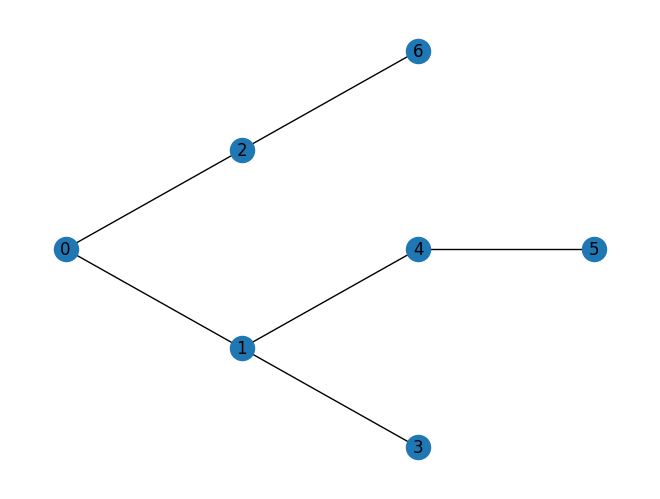

In [11]:
T = nx.Graph()
T.add_edges_from([(0,1), (0,2), (1,3), (1,4), (4,5), (2,6)])
pos = nx.bfs_layout(T, 0)
nx.draw(T, pos, with_labels=True)

In [12]:
vecttree(T)

[-7, 0, 0, 1, 1, 4, 2]


Ejercicio 4. Describa la estructura de union-find para implementar la siguiente pregunta: ¿una grafica dada mediante una matriz de incidencia es conexa?

Solucion. Antes que nada, hacemos una pequeña modificacion a la funcion $\text{union}$ que habiamos presentado anteriormente. La unica diferencia es que si $\text{union}(v,w)$ si hace algo (esto es ssi $\text{find}(u) \not = \text{find}(v)$), definimos $\text{union}(v,w) = 1$. Y si $\text{union}(v,w)$ no hacenada (esto es ssi $\text{find}(u) = \text{find}(v)$), definimos $\text{union}(v,w) = 0$. Especificamente,

```
def union(n1, n2):
  p1, p2 = find(n1), find(n2)
  if p1 == p2:
    return 0
  else:
    if rank[p1] < rank[p2]:
      par[p1] = p2
      rank[p2] += rank[p1]
    else:
      par[p2] = p1
      rank[p1] += rank[p2]
    return 1
```

Ahora bien, sea $G = (V,E)$ una grafica arbitraria. De la misma manera que en el ejercicio 2, primero creamos el bosque $F$ generado por los arboles $T_i = (\{ v_i \}, \emptyset)$. Es decir, cada arbol consiste de un solo vertice. Entonces tendremos que $\text{rank}(v) = 0$ y $\text{par}(v) = v$ para todo $v \in V$. Sea $n$ es el numero de nodos y definamos la variable $\text{conncomp}$ inicialmente como $n$. Luego hacemos un for loop sobre la lista de aristas de $G$, redefiniendo $\text{conncomp} = \text{conncomp} - \text{union}(v,w)$ en cada arista $\{v,w\}$.

```
n = G.number_of_nodes()
conncomp = n
for edge in list(G.edges):
  conncomp -= union(edge[0], edge[1])
return conncomp
```
Como restamos 1 cada que se hace una union, el valor final de $\text{conncomp}$ es el numero de componentes conexas.

In [13]:
def conncomp(G):

  n = G.number_of_nodes()
  par = [i for i in range(n)]
  rank = [0] * n

  def find(node):
    repr = node
    while repr != par[repr]:
      repr = par[repr]
    return repr

  def union(n1, n2):
    p1, p2 = find(n1), find(n2)
    if p1 == p2:
      return 0
    else:
      if rank[p1] < rank[p2]:
        par[p1] = p2
        rank[p2] += rank[p1]
      else:
        par[p2] = p1
        rank[p1] += rank[p2]
      return 1

  conncomp = n
  for edge in list(G.edges):
    conncomp -= union(edge[0], edge[1])

  return conncomp

Un ejemplo:

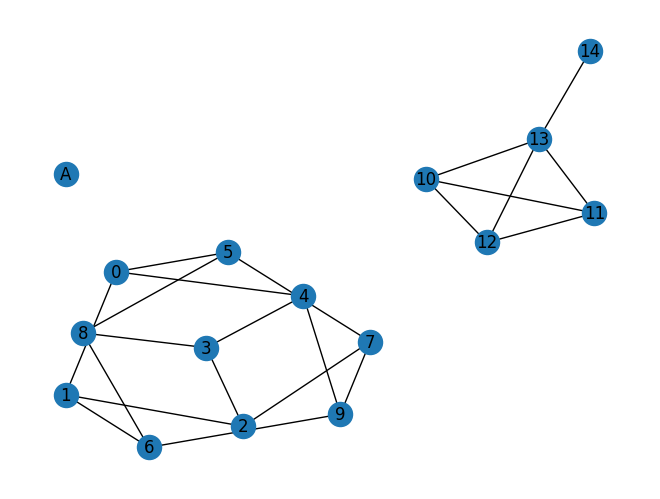

In [14]:
G1 = nx.petersen_graph()
G2 = nx.lollipop_graph(4,1)
G = nx.disjoint_union(G1, G2)
G.add_node('A')

pos = nx.nx_pydot.graphviz_layout(G)
nx.draw(G, pos, with_labels=True)

In [15]:
conncomp(G)

3